In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1

Using TensorFlow backend.
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/KTH/.local/lib/python3.6/site-packages/tensorflow/python/framework/d

In [2]:
# !pip install face_recognition

In [2]:
dataset = pd.read_csv('../Sample_Pic_OD/fer2013.csv')
train = dataset[['emotion','pixels']][:28709]
val = dataset[['emotion','pixels']][28709:]

In [3]:
train.shape, val.shape

((28709, 2), (7178, 2))

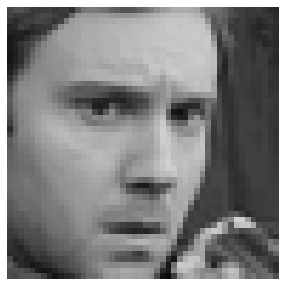

In [4]:
img = train['pixels'][0]
img = np.array(img.split(' ')).reshape(48,-1).astype('float')
plt.figure(figsize=(8,5))
plt.axis('off')
plt.imshow(img, cmap='gray', vmin=0, vmax=255)

In [5]:
label_map = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',\
            6:'Neutral'}
# just save one file for test
cv2.imwrite('../fer2013/train/{}/{}.jpg'.format(label_map[train['emotion'][0]], 1), img)

True

In [6]:
label_map = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',\
            6:'Neutral'}
# for num, i in enumerate(train.index):
#     img = train['pixels'][i]
#     img = np.array(img.split(' ')).astype('float').reshape(48,-1)
#     label = train['emotion'][i]
#     cv2.imwrite('../fer2013/train/{}/{}.jpg'.format(label_map[label], num), img)

In [7]:
# for num, i in enumerate(val.index):
#     img = val['pixels'][i]
#     img = np.array(img.split(' ')).astype('float').reshape(48,-1)
#     label = val['emotion'][i]
#     cv2.imwrite('../fer2013/validation/{}/{}.jpg'.format(label_map[label], num), img)

In [8]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 512

train_data_dir = '../fer2013/train'
validation_data_dir = '../fer2013/validation'

val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
print(validation_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [10]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001),input_shape=(48,48,1)))
# model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(7, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# # model.add(BatchNormalization())

model.add(Conv2D(7, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Flatten())

model.add(Activation("softmax"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
________________________________________________

In [12]:
# # or we can just load pretrained model
# model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_rows,img_cols,3), alpha=1.0,\
#                         include_top=False, weights='imagenet', input_tensor=None,\
#                                             pooling=None, classes=num_classes)
# model.summary()

In [14]:
filepath = os.path.join("../emotion_detector_models/model_v6_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
model.compile(loss='categorical_crossentropy',\
              optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['acc'])
nb_train_samples = train.shape[0]
nb_validation_samples = val.shape[0]
epochs = 150
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')

Epoch 1/150
56/56 [==============================] - 15s 260ms/step - loss: 1.8905 - acc: 0.2652 - val_loss: 1.8840 - val_acc: 0.2705

Epoch 00001: val_acc improved from -inf to 0.27051, saving model to ../emotion_detector_models/model_v6_1.hdf5
Epoch 2/150
56/56 [==============================] - 14s 256ms/step - loss: 1.8884 - acc: 0.2671 - val_loss: 1.8712 - val_acc: 0.2732

Epoch 00002: val_acc improved from 0.27051 to 0.27318, saving model to ../emotion_detector_models/model_v6_2.hdf5
Epoch 3/150
56/56 [==============================] - 14s 256ms/step - loss: 1.8900 - acc: 0.2642 - val_loss: 1.8593 - val_acc: 0.2697

Epoch 00003: val_acc did not improve from 0.27318
Epoch 4/150
56/56 [==============================] - 14s 255ms/step - loss: 1.8869 - acc: 0.2667 - val_loss: 1.8826 - val_acc: 0.2688

Epoch 00004: val_acc did not improve from 0.27318
Epoch 5/150
56/56 [==============================] - 14s 257ms/step - loss: 1.8890 - acc: 0.2609 - val_loss: 1.8573 - val_acc: 0.2634



56/56 [==============================] - 14s 244ms/step - loss: 1.7892 - acc: 0.3094 - val_loss: 1.7632 - val_acc: 0.3350

Epoch 00040: val_acc did not improve from 0.33558
Epoch 41/150
56/56 [==============================] - 14s 242ms/step - loss: 1.7818 - acc: 0.3179 - val_loss: 1.7704 - val_acc: 0.3305

Epoch 00041: val_acc did not improve from 0.33558
Epoch 42/150
56/56 [==============================] - 13s 241ms/step - loss: 1.7808 - acc: 0.3145 - val_loss: 1.7241 - val_acc: 0.3353

Epoch 00042: val_acc did not improve from 0.33558
Epoch 43/150
56/56 [==============================] - 13s 240ms/step - loss: 1.7851 - acc: 0.3153 - val_loss: 1.7437 - val_acc: 0.3303

Epoch 00043: val_acc did not improve from 0.33558
Epoch 44/150
56/56 [==============================] - 14s 243ms/step - loss: 1.7782 - acc: 0.3152 - val_loss: 1.6914 - val_acc: 0.3410

Epoch 00044: val_acc improved from 0.33558 to 0.34098, saving model to ../emotion_detector_models/model_v6_44.hdf5
Epoch 45/150
56/56


Epoch 00080: val_acc did not improve from 0.36579
Epoch 81/150
56/56 [==============================] - 14s 241ms/step - loss: 1.7367 - acc: 0.3394 - val_loss: 1.7276 - val_acc: 0.3563

Epoch 00081: val_acc did not improve from 0.36579
Epoch 82/150
56/56 [==============================] - 14s 242ms/step - loss: 1.7302 - acc: 0.3440 - val_loss: 1.6765 - val_acc: 0.3638

Epoch 00082: val_acc did not improve from 0.36579
Epoch 83/150
56/56 [==============================] - 13s 240ms/step - loss: 1.7304 - acc: 0.3401 - val_loss: 1.6705 - val_acc: 0.3666

Epoch 00083: val_acc improved from 0.36579 to 0.36664, saving model to ../emotion_detector_models/model_v6_83.hdf5
Epoch 84/150
38/56 [===================>..........] - ETA: 3s - loss: 1.7225 - acc: 0.3455

KeyboardInterrupt: 

In [11]:
model.load_weights('../emotion_detector_models/model_v6_71+83.hdf5')
filepath = os.path.join("../emotion_detector_models/model_v6_final.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
model.compile(loss='categorical_crossentropy',\
              optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['acc'])
nb_train_samples = train.shape[0]
nb_validation_samples = val.shape[0]
epochs = 100
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
56/56 [==============================] - 40s 714ms/step - loss: 1.6678 - acc: 0.3745 - val_loss: 1.6033 - val_acc: 0.3796

Epoch 00001: val_acc improved from -inf to 0.37960, saving model to ../emotion_detector_models/model_v6_final.hdf5
Epoch 2/100
56/56 [==============================] - 14s 253ms/step - loss: 1.6671 - acc: 0.3734 - val_loss: 1.6015 - val_acc: 0.3942

Epoch 00002: val_acc improved from 0.37960 to 0.39424, saving model to ../emotion_detector_models/model_v6_final.hdf5
Epoch 3/100
56/56 [==============================] - 14s 251ms/step - loss: 1.6647 - acc: 0.3739 - val_loss: 1.6386 - val_acc: 0.3890

Epoch 00003: val_acc did not improve from 0.39424
Epoch 4/100
56/56 [==============================] - 14s 253ms/step - loss: 1.6676 - acc: 0.3755 - val_loss: 1.6024 - val_acc: 0.3966

Epoch 00004: val_acc improved from 0.39424 to 0.39664, saving model to ../emotion_detector_models/model_v6_final.hdf5
Epoch 5/100

56/56 [==============================] - 14s 248ms/step - loss: 1.6380 - acc: 0.3886 - val_loss: 1.6461 - val_acc: 0.3968

Epoch 00042: val_acc did not improve from 0.40099
Epoch 43/100
56/56 [==============================] - 13s 241ms/step - loss: 1.6423 - acc: 0.3853 - val_loss: 1.6512 - val_acc: 0.3957

Epoch 00043: val_acc did not improve from 0.40099
Epoch 44/100
56/56 [==============================] - 14s 241ms/step - loss: 1.6434 - acc: 0.3887 - val_loss: 1.6323 - val_acc: 0.3948

Epoch 00044: val_acc did not improve from 0.40099
Epoch 45/100
56/56 [==============================] - 14s 244ms/step - loss: 1.6360 - acc: 0.3877 - val_loss: 1.7042 - val_acc: 0.3989

Epoch 00045: val_acc did not improve from 0.40099
Epoch 46/100
56/56 [==============================] - 14s 249ms/step - loss: 1.6400 - acc: 0.3873 - val_loss: 1.6372 - val_acc: 0.3993

Epoch 00046: val_acc did not improve from 0.40099
Epoch 47/100
56/56 [==============================] - 15s 265ms/step - loss: 1.6315

KeyboardInterrupt: 

In [ ]:
print(model_info.history.keys())

import matplotlib.pyplot as plt
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# MoblieNet

In [17]:
num_classes = 7
img_rows, img_cols = 48, 48
batch_size = 32

train_data_dir = '../fer2013/train'
validation_data_dir = '../fer2013/validation'

val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [22]:
# or we can just load pretrained model
model = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_rows,img_cols,1), alpha=1.0,\
                        include_top=False, weights=None, input_tensor=None,\
                                            pooling=None, classes=num_classes)
model.summary()

Model: "mobilenetv2_1.00_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [23]:
type(model)

keras.engine.training.Model

In [24]:
from keras.models import Model

x = model.output
x = Flatten()(x)
x = Dense(256)(x)
x = Dense(7)(x)

model = Model(model.input, x)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 49, 49, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 24, 24, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 24, 24, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [25]:
filepath = os.path.join("../emotion_detector_models/model_mobile_{epoch}.hdf5")

checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                             monitor='val_acc',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
callbacks = [checkpoint]
model.compile(loss='categorical_crossentropy',\
              optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['acc'])
nb_train_samples = 28709
nb_validation_samples = 3589
epochs = 150
model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

# plot_model_history(model_info)
# model.save_weights('model.h5')

Epoch 1/150
897/897 [==============================] - 52s 58ms/step - loss: 8.5699 - acc: 0.2489 - val_loss: 8.0590 - val_acc: 0.2447

Epoch 00001: val_acc improved from -inf to 0.24470, saving model to ../emotion_detector_models/model_mobile_1.hdf5
Epoch 2/150
897/897 [==============================] - 45s 50ms/step - loss: 8.6645 - acc: 0.2506 - val_loss: 10.5775 - val_acc: 0.2497

Epoch 00002: val_acc improved from 0.24470 to 0.24972, saving model to ../emotion_detector_models/model_mobile_2.hdf5
Epoch 3/150
897/897 [==============================] - 46s 51ms/step - loss: 8.7077 - acc: 0.2507 - val_loss: 9.0664 - val_acc: 0.2493

Epoch 00003: val_acc did not improve from 0.24972
Epoch 4/150
897/897 [==============================] - 45s 50ms/step - loss: 8.6729 - acc: 0.2487 - val_loss: 9.0664 - val_acc: 0.2453

Epoch 00004: val_acc did not improve from 0.24972
Epoch 5/150
897/897 [==============================] - 45s 51ms/step - loss: 8.6314 - acc: 0.2308 - val_loss: 7.5554 - val

897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1387 - val_loss: 1.1921e-07 - val_acc: 0.1323

Epoch 00086: val_acc did not improve from 0.25698
Epoch 87/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1399 - val_loss: 1.1921e-07 - val_acc: 0.1305

Epoch 00087: val_acc did not improve from 0.25698
Epoch 88/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1396 - val_loss: 1.1921e-07 - val_acc: 0.1409

Epoch 00088: val_acc did not improve from 0.25698
Epoch 89/150
897/897 [==============================] - 44s 49ms/step - loss: 1.1921e-07 - acc: 0.1394 - val_loss: 1.1921e-07 - val_acc: 0.1289

Epoch 00089: val_acc did not improve from 0.25698
Epoch 90/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1376 - val_loss: 1.1921e-07 - val_acc: 0.1381

Epoch 00090: val_acc did not improve from 0.25698
Epoch 91/150
897/897 [================

897/897 [==============================] - 45s 51ms/step - loss: 1.1921e-07 - acc: 0.1377 - val_loss: 1.1921e-07 - val_acc: 0.1275

Epoch 00128: val_acc did not improve from 0.25698
Epoch 129/150
897/897 [==============================] - 44s 49ms/step - loss: 1.1921e-07 - acc: 0.1404 - val_loss: 1.1921e-07 - val_acc: 0.1311

Epoch 00129: val_acc did not improve from 0.25698
Epoch 130/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1376 - val_loss: 1.1921e-07 - val_acc: 0.1429

Epoch 00130: val_acc did not improve from 0.25698
Epoch 131/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1391 - val_loss: 1.1921e-07 - val_acc: 0.1331

Epoch 00131: val_acc did not improve from 0.25698
Epoch 132/150
897/897 [==============================] - 45s 50ms/step - loss: 1.1921e-07 - acc: 0.1406 - val_loss: 1.1921e-07 - val_acc: 0.1364

Epoch 00132: val_acc did not improve from 0.25698
Epoch 133/150
897/897 [===========

In [10]:
model.layers

In [11]:
for layer in model.layers:
    print(layer.trainable)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
